In [37]:
# Import libraries
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
import matplotlib.pyplot as plt
from numpy import arange, meshgrid
#
from smt.sampling_methods import LHS
# Seeds
torch.manual_seed(123)
np.random.seed(123)
def train(epoch):
    model.train()
    def closure():
        optimizer.zero_grad()                                                     # Optimizer
        loss_pde = model.loss_pde(x_int_train)                                    # Loss function of PDE
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,v_ic_train,p_ic_train)   # Loss function of IC
        loss = loss_pde + 10*loss_ic                                          # Total loss function G(theta)

        # Print iteration, loss of PDE and ICs
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
        loss.backward()
        return loss

    # Optimize loss function
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
    
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    v_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition

    # rho, p - initial condition
    for i in range(N):
        if (x[i][1] >= 0.5 and x[i][2]>=0.5):
            rho_init[i] = 1.0
            u_init[i] = 0.75
            v_init[i] = -0.5
            p_init[i] = 1.0
        elif(x[i][1] <= 0.5 and x[i][2]>=0.5):
            rho_init[i] = 2.0
            u_init[i] = 0.75
            v_init[i] = 0.5
            p_init[i] = 1.0
        elif(x[i][1] <= 0.5 and x[i][2]<=0.5):
            rho_init[i] = 1.0
            u_init[i] = -0.75
            v_init[i] = 0.5
            p_init[i] = 1.0
        else:
            rho_init[i] = 3.0
            u_init[i] = -0.75
            v_init[i] = -0.5
            p_init[i] = 1.0

    return rho_init, u_init, v_init,p_init

    
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(3, 30))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 10):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(30, 4))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                # Neural network
        rho,p,u,v = y[:, 0:1], y[:, 1:2], y[:, 2:3],y[:,3:]
        
        gamma = 1.4                                                    # Heat Capacity Ratio
        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_t, rho_x,rho_y = drho_g[:, :1], drho_g[:, 1:2],drho_g[:,2:]                    # Partial derivatives rho_t, rho_x
        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_t, u_x, u_y = du_g[:, :1], du_g[:, 1:2], du_g[:,2:]                            # Partial derivatives u_t, u_x
        dv_g = gradients(v, x)[0]                                      # Gradient [u_t, u_x]
        v_t, v_x, v_y = dv_g[:, :1], dv_g[:, 1:2], dv_g[:,2:]                            # Partial derivatives u_t, u_x
        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_t, p_x, p_y = dp_g[:, :1], dp_g[:, 1:2], dp_g[:,2:]                            # Partial derivatives p_t, p_x
        deltau = u_x + v_y
        lam = 0.1*(abs(deltau) - deltau)+1# 0.01*(rho_x+rho_y) + 1
        f = (((rho_t+rho*deltau+u*rho_x + v*rho_y)/lam)**2).mean() +\
            (((rho*u_t+rho*u*u_x+rho*v*u_y+p_x)/lam)**2).mean() +\
            (((rho*v_t+rho*u*v_x+rho*v*v_y+p_y)/lam)**2).mean() +\
            (((p_t+u*p_x+v*p_y+1.4*p*deltau)/lam)**2).mean()

        return f
    def loss_ic(self, x_ic, rho_ic, u_ic, v_ic,p_ic):
        U_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn,v_ic_nn = U_ic[:, 0], U_ic[:, 1], U_ic[:, 2],U_ic[:,3]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean() +\
               ((v_ic_nn - v_ic) ** 2).mean()

        return loss_ics
# Solve Euler equations using PINNs
# def main():
  # Initialization

In [38]:
device = torch.device('cuda')                                          # Run on CPU
lr = 0.0005                                                          # Learning rate
num_x = 1000                                                        # Number of points in t
num_y = 1000                                                        # Number of points in t
num_t = 2000                                                         # Number of points in x
num_i_train = 10000                                                 # Random sampled points from IC0
num_f_train = 500000                                                 # Random sampled points in interior
num_test = 1000                                                 # Random sampled points in interior
x = np.linspace(0.0, 1.0, num_x)                                   # Partitioned spatial axis
y = np.linspace(0.0, 1.0, num_y)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, num_t)                                        # Partitioned time axis


#id_ic = np.random.choice(num_x, num_i_train, replace=False)           # Random sample numbering for IC

xlimits = np.array([[0.0, 0.2], [0.0, 1.0], [0.0,1.0]])
sampling = LHS(xlimits=xlimits)
x_int_train = sampling(num_f_train)

xlimits_ic = np.array([[0.0, 0.0], [0.0, 1.0], [0.0,1.0]])
sampling_ic = LHS(xlimits=xlimits_ic)
x_ic_train =  sampling_ic(num_i_train)                                           # Vectorized whole domain


xlimits_test = np.array([[0.2, 0.2], [0.0, 1.0],[0.0, 1.0]])
sampling_test = LHS(xlimits=xlimits_test)
x_test =  sampling_test(num_test)                                           # Vectorized whole domain

#id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)      # Random sample numbering for interior
#t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
#T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
#X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
#x_int = X[:, 0][id_f, None]                                           # Random x - interior
#t_int = T[:, 0][id_f, None]                                           # Random t - interior
#x_int_train = np.hstack((t_int, x_int))                               # Random (x,t) - vectorized
#x_ic = x_grid[id_ic, 0][:, None]                                      # Random x - initial condition
#t_ic = t_grid[id_ic, 0][:, None]                                      # random t - initial condition
#x_ic_train = np.hstack((t_ic, x_ic))                                  # Random (x,t) - vectorized





In [39]:
rho_ic_train, u_ic_train,v_ic_train, p_ic_train = IC(x_ic_train)                       # Initial condition evaluated at random sample

x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
v_ic_train = torch.tensor(v_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)#
#
#x_ic_train = x_ic_train.clone().detach().requires_grad_(True)
#x_int_train = x_int_train.clone().detach().requires_grad_(True)
#x_test_train = x_test_train.clone().detach().requires_grad_(True)
#u_ic_train = u_ic_train.clone().detach().requires_grad_(True)
#v_ic_train = v_ic_train.clone().detach().requires_grad_(True)
#p_ic_train = p_ic_train.clone().detach().requires_grad_(True)
#rho_ic_train = rho_ic_train.clone().detach().requires_grad_(True)

# Initialize neural network
model = DNN().to(device)

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.LBFGS(model.parameters(),lr=0.001,max_iter=50)
#
# Print CPU
print('Start training...')
#__name__ == '__main__':``
#

Start training...


In [40]:
epochs = 10000
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')


epoch 1 loss_pde:0.00000476, loss_ic:5.13748407
epoch 1: loss 51.374844
epoch 2 loss_pde:0.00000591, loss_ic:5.07735682
epoch 2: loss 50.773575
epoch 3 loss_pde:0.00000723, loss_ic:5.01644373
epoch 3: loss 50.164444
epoch 4 loss_pde:0.00000876, loss_ic:4.95463705
epoch 4: loss 49.546379
epoch 5 loss_pde:0.00001054, loss_ic:4.89182949
epoch 5: loss 48.918308
epoch 6 loss_pde:0.00001261, loss_ic:4.82786369
epoch 6: loss 48.278648
epoch 7 loss_pde:0.00001503, loss_ic:4.76254559
epoch 7: loss 47.625473
epoch 8 loss_pde:0.00001785, loss_ic:4.69568443
epoch 8: loss 46.956863
epoch 9 loss_pde:0.00002115, loss_ic:4.62711096
epoch 9: loss 46.271133
epoch 10 loss_pde:0.00002502, loss_ic:4.55667257
epoch 10: loss 45.566753
epoch 11 loss_pde:0.00002958, loss_ic:4.48422623
epoch 11: loss 44.842293
epoch 12 loss_pde:0.00003495, loss_ic:4.40963745
epoch 12: loss 44.096409
epoch 13 loss_pde:0.00004129, loss_ic:4.33277464
epoch 13: loss 43.327789
epoch 14 loss_pde:0.00004876, loss_ic:4.25351334
epoch 1

In [49]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.5,max_iter=20)
epochs = 1000
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

epoch 1 loss_pde:0.01259319, loss_ic:0.00075606
epoch 1 loss_pde:8.19971371, loss_ic:0.00227638
epoch 1 loss_pde:2.07129860, loss_ic:0.00114259


epoch 1 loss_pde:0.36345157, loss_ic:0.00114160
epoch 1 loss_pde:0.09414566, loss_ic:0.00112555
epoch 1 loss_pde:0.03675720, loss_ic:0.00119208
epoch 1 loss_pde:0.02070463, loss_ic:0.00120438
epoch 1 loss_pde:0.01536468, loss_ic:0.00116470
epoch 1 loss_pde:0.01354087, loss_ic:0.00108885
epoch 1 loss_pde:0.01295034, loss_ic:0.00098573
epoch 1 loss_pde:0.01282221, loss_ic:0.00088231
epoch 1 loss_pde:0.01278614, loss_ic:0.00082010
epoch 1 loss_pde:0.01279274, loss_ic:0.00078398
epoch 1 loss_pde:0.01270150, loss_ic:0.00077415
epoch 1 loss_pde:0.01265555, loss_ic:0.00076828
epoch 1 loss_pde:0.01263712, loss_ic:0.00076508
epoch 1 loss_pde:0.01262996, loss_ic:0.00076334
epoch 1 loss_pde:0.01262586, loss_ic:0.00076235
epoch 1 loss_pde:0.01262205, loss_ic:0.00076166
epoch 1 loss_pde:0.01261750, loss_ic:0.00076092
epoch 1: loss 0.020154
epoch 2 loss_pde:0.01261214, loss_ic:0.00075997
epoch 2 loss_pde:0.01260865, loss_ic:0.00075880
epoch 2 loss_pde:0.01260496, loss_ic:0.00075785
epoch 2 loss_pde:

In [41]:
# Evaluate on the whole computational domain
#u = to_numpy(model(x_test))
#x = to_numpy(x_test)
for k in range(10):
    x = np.linspace(0.0, 1.0, 201)                                   # Partitioned spatial axis
    y = np.linspace(0.0, 1.0, 200)                                   # Partitioned spatial axis
    T = 0.008*(k+1)
    t = np.linspace(T, T, 1)                                        # Partitioned time axis
    t_grid, x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
    T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
    X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
    Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
    x_test = np.hstack((T, X, Y))                                            # Vectorized whole domain
    x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
    u = to_numpy(model(x_test))
    #Xp,Yp = meshgrid(x,y)
    
    ue = np.zeros((201,200))
    for i in range(0,201):
        for j in range(0,200):
            ue[i,j] = u[j*200+i,0]
    
    uo = ue.flatten()[:,None]
    #uxy= np.hstack((X, Y,uo))                                            # Vectorized whole domain

    plt.figure()
    plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,50)
    #plt.pcolor(x_grid[:,0,:],y_grid[:,0,:],ue)
    #plt.colorbar(x_grid[:,0,:],y_grid[:,0,:],ue)
    #plt.scatter(x_int_train[:,1],)
    #plt.pcolor(x[:],u[:,1])
    #plt.pcolor(x[:],u[:,2])
    plt.savefig("temp0{}.png".format(k),dpi=200)
    plt.clf()
    #plt.show()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [54]:
# Evaluate on the whole computational domain
#u = to_numpy(model(x_test))
#x = to_numpy(x_test)
x = np.linspace(0.0, 1.0, 100)                                   # Partitioned spatial axis
y = np.linspace(0.0, 1.0, 100)                                   # Partitioned spatial axis
#jT = 0.008*(k+1)
t = np.linspace(0.4,0.4, 1)                                        # Partitioned time axis
t_grid, x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X, Y))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u = to_numpy(model(x_test))
#Xp,Yp = meshgrid(x,y)
ue = np.zeros((100,100))
for i in range(0,100):
    for j in range(0,100):
        ue[i,j] = u[i*100+j,0]

uo1 = ue.flatten()[:,None]
#uxy= np.hstack((X, Y,ue))                                            # Vectorized whole domain


ue = np.zeros((100,100))
for i in range(0,100):
    for j in range(0,100):
        ue[i,j] = u[i*100+j,1]

uo2 = ue.flatten()[:,None]

ue = np.zeros((100,100))
for i in range(0,100):
    for j in range(0,100):
        ue[i,j] = u[i*100+j,2]

uo3 = ue.flatten()[:,None]

ue = np.zeros((100,100))
for i in range(0,100):
    for j in range(0,100):
        ue[i,j] = u[i*100+j,3]

uo4 = ue.flatten()[:,None]
#uxy= np.hstack((X, Y,ue))                                            # Vectorized whole domain

var1 = """TITLE="Euler"
 VARIABLES="x","y","rho","p","u","v"
ZONE I=         100 J=         100 F=POINT
"""
filename = "Riemann2D_Case6.dat" 
uo = ue.flatten()[:,None]
#uex = ue.flatten()[:,None]
uxy= np.hstack((X, Y,uo1,uo2,uo3,uo4)) 
f = open(filename,'w')
f.write(var1)
np.savetxt(f, uxy)# Vectorized whole domain
f.close()
#plt.figure()
#plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,50)
#plt.pcolor(x_grid[:,0,:],y_grid[:,0,:],ue)
#plt.colorbar(x_grid[:,0,:],y_grid[:,0,:],ue)
#plt.scatter(x_int_train[:,1],)
#plt.pcolor(x[:],u[:,1])
#plt.pcolor(x[:],u[:,2])
#plt.savefig("temp0{}.png".format(k),dpi=200)
#plt.clf()
#plt.show()


In [47]:
np.savetxt('Stablerho.txt', uxy)

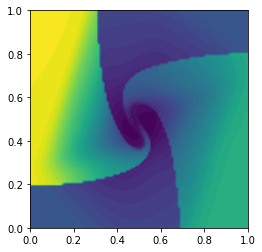

In [51]:
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,50)
#plt.pcolor(x_grid[:,0,:],y_grid[:,0,:],ue)
#plt.colorbar(x_grid[:,0,:],y_grid[:,0,:],ue)
#plt.scatter(x_int_train[:,1],)
#plt.pcolor(x[:],u[:,1])
#plt.pcolor(x[:],u[:,2])
ax = plt.gca()
ax.set_aspect(1)
plt.savefig("test_rasterization.pdf", dpi=150)
plt.show()


In [62]:
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#surf = ax.plot_surface(x_grid[:,0,:], y_grid[:,0,:], ue, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)
#
## Customize the z axis.
#ax.set_zlim(0, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
## A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
#
## Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.show()


In [24]:
device1 = torch.device("cpu")
#model.load_state_dict(torch.load(PATH))
model = model.to(device1)
torch.save(model,'2DRiemanncase6.pt')

In [26]:
model = torch.load('2DRiemanncase5.pt')

model = model.to(device)

In [ ]:
torch.save(model,'2DRiemanncase1.pt')

In [30]:
model

DNN(
  (net): Sequential(
    (Linear_layer_1): Linear(in_features=3, out_features=30, bias=True)
    (Tanh_layer_1): Tanh()
    (Linear_layer_2): Linear(in_features=30, out_features=30, bias=True)
    (Tanh_layer_2): Tanh()
    (Linear_layer_3): Linear(in_features=30, out_features=30, bias=True)
    (Tanh_layer_3): Tanh()
    (Linear_layer_4): Linear(in_features=30, out_features=30, bias=True)
    (Tanh_layer_4): Tanh()
    (Linear_layer_5): Linear(in_features=30, out_features=30, bias=True)
    (Tanh_layer_5): Tanh()
    (Linear_layer_6): Linear(in_features=30, out_features=30, bias=True)
    (Tanh_layer_6): Tanh()
    (Linear_layer_7): Linear(in_features=30, out_features=30, bias=True)
    (Tanh_layer_7): Tanh()
    (Linear_layer_8): Linear(in_features=30, out_features=30, bias=True)
    (Tanh_layer_8): Tanh()
    (Linear_layer_9): Linear(in_features=30, out_features=30, bias=True)
    (Tanh_layer_9): Tanh()
    (Linear_layer_final): Linear(in_features=30, out_features=4, bias=True)